In [25]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torch import nn


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

In [2]:
batch_size=64

NUM_CLASSES = 10
NUM_FEATURES = 28*28
RANDOM_SEED = 42

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [4]:
transform = transforms.Compose([transforms.ToTensor()])

train_data = datasets.MNIST("./", train=True,
                            transform=transform, download=True)
test_data = datasets.MNIST("./", train=False,
                            transform=transform, download=True)

In [5]:
train_dataset = DataLoader(train_data, batch_size=batch_size, shuffle=False)
test_dataset = DataLoader(test_data, batch_size=batch_size, shuffle=False)

In [6]:
class MNISTModel(nn.Module):
  def __init__(self,input_features, output_features, hidden_units=12):
    super().__init__()
    self.stack_layers = nn.Sequential(
        nn.Linear(in_features=input_features, out_features=hidden_units),
        nn.ReLU(),
        nn.Linear(in_features=hidden_units, out_features=hidden_units),
        nn.ReLU(),
        nn.Linear(in_features=hidden_units, out_features=hidden_units),
        nn.ReLU(),
        nn.Linear(in_features=hidden_units, out_features=output_features)
    )

  def forward(self, x):
    return self.stack_layers(x)

In [8]:
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc

In [67]:
def train_one_epoch(trained_model, opt, loss_fn):
  train_acc = []
  train_loss = []
  for i, data in enumerate(train_dataset):
    X, labels = data
    X = X.view(X.size(0), -1).to(device)
    labels = labels.to(device)
    opt.zero_grad()
    y_logits = trained_model(X).squeeze()
    y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)
    loss = loss_fn(y_logits, labels)
    acc = accuracy_fn(y_true=labels, y_pred=y_pred)
    loss.backward()
    opt.step()
    train_acc.append(acc)
    train_loss.append(loss.item())
  return train_loss, train_acc


In [68]:
def predic_one_epoch(trained_model, loss_fn):
  preds, labels = [], []
  test_acc = []
  test_loss = []
  for i, data in enumerate(test_dataset):
    X, y_test = data
    X = X.view(X.size(0), -1).to(device)
    y_test = y_test.to(device)
    y_logits = trained_model(X).squeeze()
    y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)
    loss = loss_fn(y_logits, y_test)
    acc = accuracy_fn(y_true=y_test, y_pred=y_pred)
    labels.extend(y_test.cpu().numpy())
    preds.extend(y_pred.cpu().numpy())
    test_acc.append(acc)
    test_loss.append(loss.item())
  cm = confusion_matrix(labels, preds)
  return preds, test_acc, test_loss, cm



In [69]:
def plotting_metrics(epochs, train_metric, test_metric, type='loss'):
  plt.plot([i for i in range(0, epochs)], train_metric, label=f"Train {type}")
  plt.plot([i for i in range(0, epochs)], test_metric, label=f"Test {type}")
  plt.title(f"Training and test {type} curves")
  plt.ylabel(f"{type}")
  plt.xlabel("Epochs")
  plt.legend()
  plt.show()

In [78]:
torch.manual_seed(42)

def result_pipiline(model, loss_fn, opt, epochs):
    res_train_loss, res_train_acc = [], []
    res_test_loss, res_test_acc = [], []
    for epoch in range(1, epochs+1):
      running_loss = 0.0
      model.train()
      train_loss, train_acc = train_one_epoch(model, opt, loss_fn)
      train_loss = np.mean(train_loss)
      train_acc = np.mean(train_acc)
      res_train_loss.append(train_loss)
      res_train_acc.append(train_acc)
      model.eval()
      with torch.inference_mode():
        test_preds, test_acc, test_loss, cm = predic_one_epoch(model, loss_fn)
        test_acc = np.mean(test_acc)
        test_loss = np.mean(test_loss)
        res_test_loss.append(test_loss)
        res_test_acc.append(test_acc)
      if epoch % 10 == 0:
          print(f"Epoch: {epoch} | Loss: {train_loss:.5f}, Acc: {train_acc:.2f}% | Test Loss: {test_loss:.5f}, Test Acc: {test_acc:.2f}%")
      if epoch == (epochs - 1):
        print('Test confusion matrix\n', cm)
    plotting_metrics(epochs, res_train_loss, res_test_loss, 'loss')
    plotting_metrics(epochs, res_train_acc, res_test_acc, 'accuracy')

    return test_preds

Epoch: 10 | Loss: 0.16779, Acc: 95.04% | Test Loss: 0.21626, Test Acc: 93.68%
Epoch: 20 | Loss: 0.14347, Acc: 95.67% | Test Loss: 0.22847, Test Acc: 93.62%
Epoch: 30 | Loss: 0.13151, Acc: 96.04% | Test Loss: 0.22385, Test Acc: 93.74%
Epoch: 40 | Loss: 0.11935, Acc: 96.41% | Test Loss: 0.21967, Test Acc: 94.22%
Epoch: 50 | Loss: 0.11374, Acc: 96.57% | Test Loss: 0.23551, Test Acc: 93.90%
Epoch: 60 | Loss: 0.10844, Acc: 96.78% | Test Loss: 0.23569, Test Acc: 94.27%
Epoch: 70 | Loss: 0.10726, Acc: 96.80% | Test Loss: 0.22959, Test Acc: 94.46%
Epoch: 80 | Loss: 0.10369, Acc: 96.91% | Test Loss: 0.29842, Test Acc: 93.34%
Epoch: 90 | Loss: 0.10157, Acc: 96.98% | Test Loss: 0.25772, Test Acc: 94.00%
Test confusion matrix
 [[ 950    1    4    1    0    6    8    2    8    0]
 [   0 1110    2    6    0    1    1    2   12    1]
 [  16    6  935   39    6    2    5    7   16    0]
 [   2    5    7  944    1   20    1    7   19    4]
 [   4    1    4    0  930    1    8    1    1   32]
 [   5    

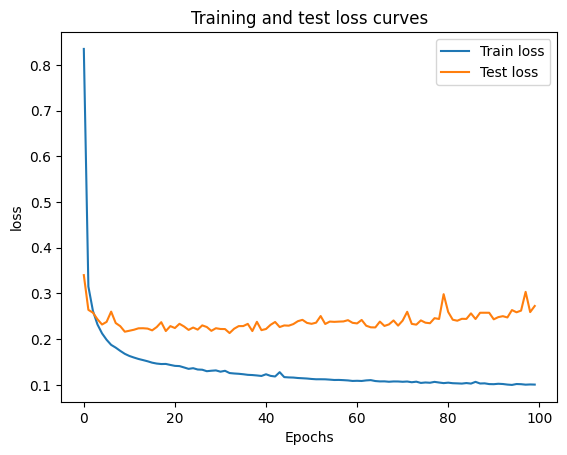

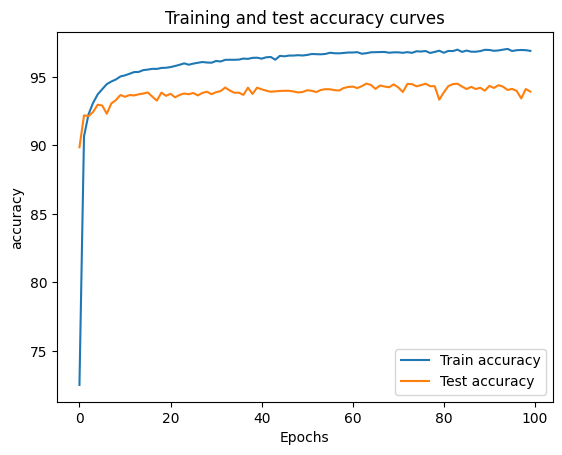

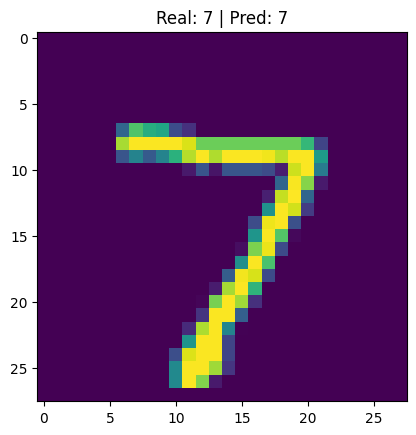

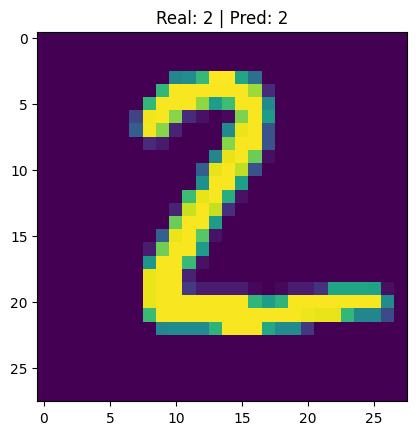

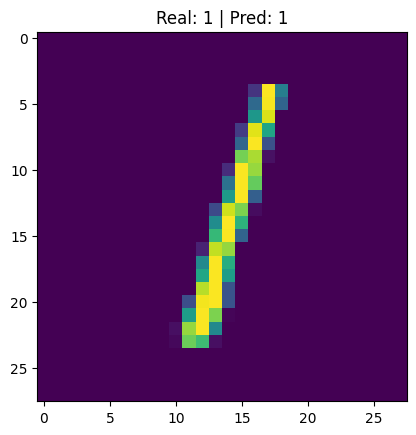

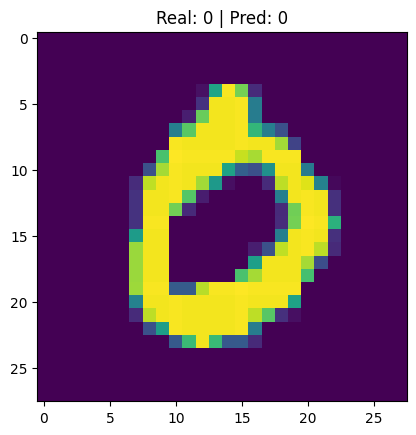

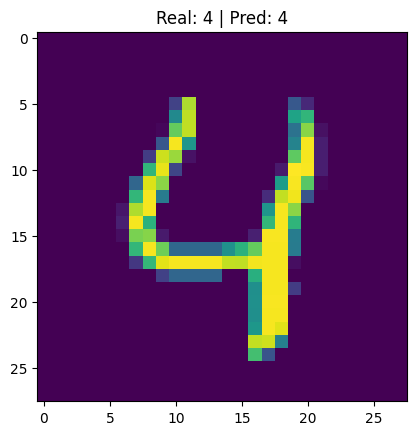

In [76]:
model = MNISTModel(input_features=NUM_FEATURES,
                   output_features=NUM_CLASSES,
                   hidden_units=12).to(device)
loss_fn = nn.CrossEntropyLoss()
opt = torch.optim.SGD(model.parameters(), lr=0.1)
preds = result_pipiline(model, loss_fn, opt, epochs=100)

data_iter = iter(test_dataset)
images, labels = next(data_iter)
for i in range(5):
    img = images[i].numpy().transpose((1, 2, 0))
    plt.imshow(img)
    plt.title(f"Real: {labels[i].item()} | Pred: {preds[i].item()}")
    plt.show()

Epoch: 10 | Loss: 0.23426, Acc: 93.48% | Test Loss: 0.31474, Test Acc: 91.83%
Epoch: 20 | Loss: 0.21266, Acc: 94.29% | Test Loss: 0.27166, Test Acc: 93.25%
Epoch: 30 | Loss: 0.20599, Acc: 94.39% | Test Loss: 0.30599, Test Acc: 92.98%
Epoch: 40 | Loss: 0.19871, Acc: 94.68% | Test Loss: 0.29998, Test Acc: 93.34%
Epoch: 50 | Loss: 0.19388, Acc: 94.85% | Test Loss: 0.32042, Test Acc: 92.75%
Epoch: 60 | Loss: 0.19213, Acc: 94.81% | Test Loss: 0.32143, Test Acc: 92.99%
Epoch: 70 | Loss: 0.18822, Acc: 95.01% | Test Loss: 0.30201, Test Acc: 93.23%
Epoch: 80 | Loss: 0.19246, Acc: 94.80% | Test Loss: 0.34230, Test Acc: 92.67%
Epoch: 90 | Loss: 0.18902, Acc: 95.03% | Test Loss: 0.33873, Test Acc: 92.53%
Test confusion matrix
 [[ 933    0    5    0    1   10   19    1   11    0]
 [   0 1097    5    6    3    1    2    2   18    1]
 [   8    7  896   44   14    7   15   10   31    0]
 [   3    1   13  930    2   28    1   13   12    7]
 [   2    0    4    0  949    3    9    1    4   10]
 [   4    

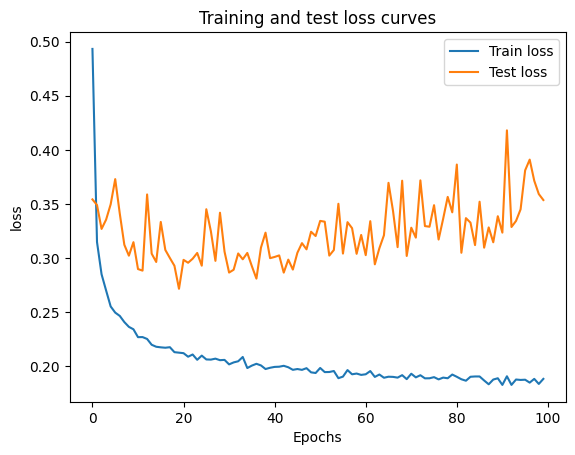

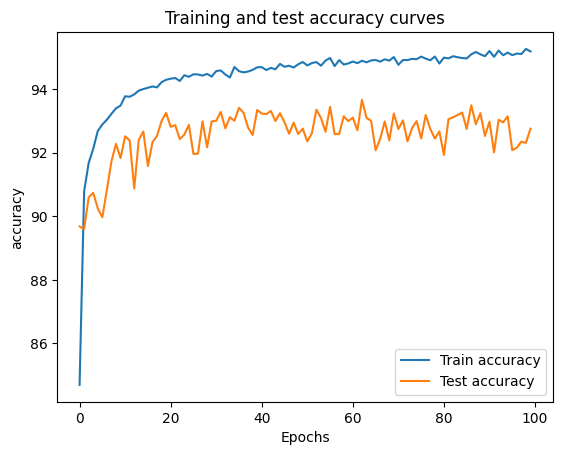

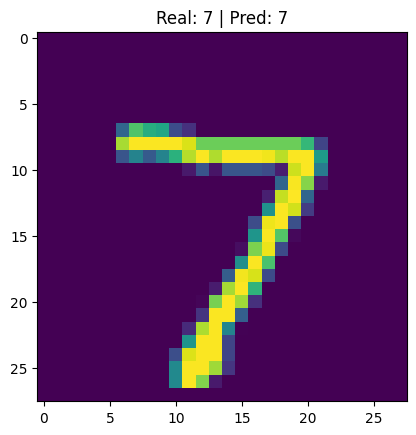

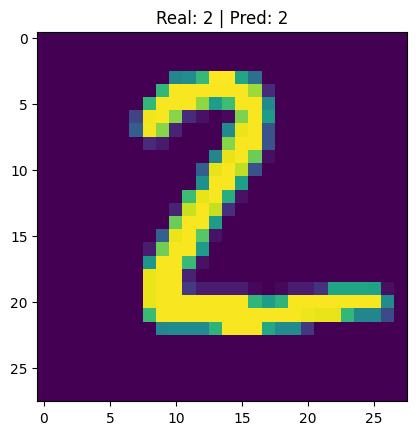

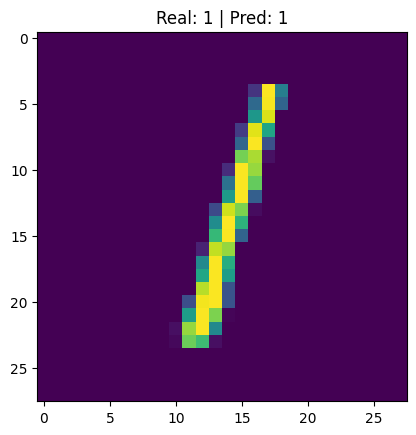

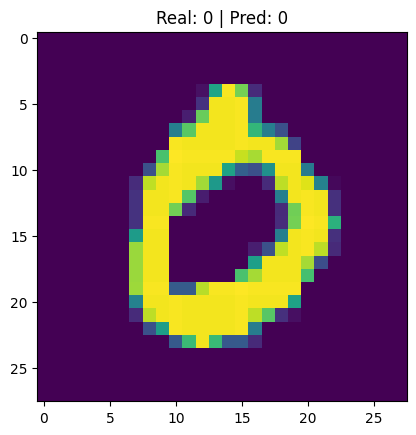

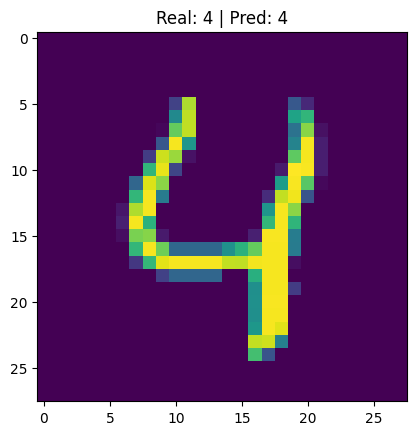

In [79]:
model = MNISTModel(input_features=NUM_FEATURES,
                   output_features=NUM_CLASSES,
                   hidden_units=12).to(device)
loss_fn = nn.CrossEntropyLoss()
opt = torch.optim.Adam(model.parameters(), lr=0.01)
preds = result_pipiline(model, loss_fn, opt, epochs=100)

data_iter = iter(test_dataset)
images, labels = next(data_iter)
for i in range(5):
    img = images[i].numpy().transpose((1, 2, 0))
    plt.imshow(img)
    plt.title(f"Real: {labels[i].item()} | Pred: {preds[i].item()}")
    plt.show()

Examples of incorrect predictions

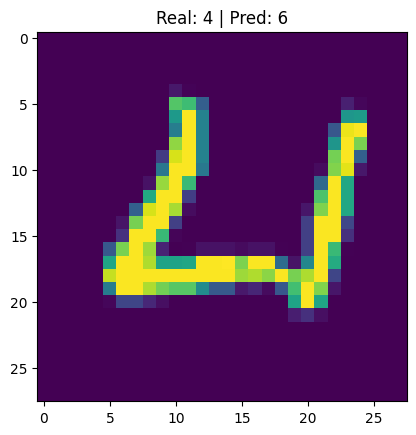

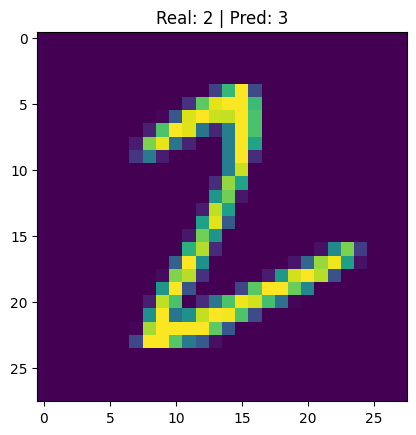

In [91]:
for i in [33, 38]:
  img = images[i].numpy().transpose((1, 2, 0))
  plt.imshow(img)
  plt.title(f"Real: {labels[i].item()} | Pred: {preds[i].item()}")
  plt.show()

Epoch: 10 | Loss: 0.10937, Acc: 96.82% | Test Loss: 0.15207, Test Acc: 95.46%
Epoch: 20 | Loss: 0.07911, Acc: 97.65% | Test Loss: 0.15403, Test Acc: 96.00%
Epoch: 30 | Loss: 0.06521, Acc: 98.08% | Test Loss: 0.17905, Test Acc: 95.63%
Epoch: 40 | Loss: 0.05591, Acc: 98.30% | Test Loss: 0.19857, Test Acc: 95.54%
Epoch: 50 | Loss: 0.05122, Acc: 98.37% | Test Loss: 0.21707, Test Acc: 95.65%
Epoch: 60 | Loss: 0.04698, Acc: 98.53% | Test Loss: 0.22885, Test Acc: 95.51%
Epoch: 70 | Loss: 0.04463, Acc: 98.56% | Test Loss: 0.27732, Test Acc: 95.20%
Epoch: 80 | Loss: 0.03917, Acc: 98.75% | Test Loss: 0.25776, Test Acc: 95.41%
Epoch: 90 | Loss: 0.03627, Acc: 98.85% | Test Loss: 0.26400, Test Acc: 95.72%
Epoch: 100 | Loss: 0.03420, Acc: 98.86% | Test Loss: 0.29190, Test Acc: 95.54%
Epoch: 110 | Loss: 0.03524, Acc: 98.84% | Test Loss: 0.30505, Test Acc: 95.51%
Epoch: 120 | Loss: 0.03493, Acc: 98.88% | Test Loss: 0.31328, Test Acc: 95.58%
Epoch: 130 | Loss: 0.03403, Acc: 98.91% | Test Loss: 0.32278,

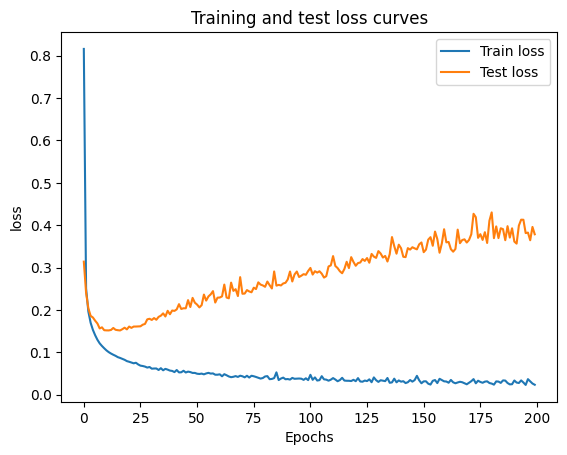

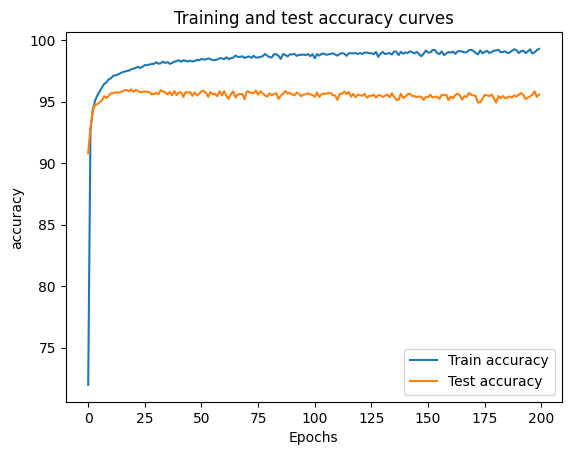

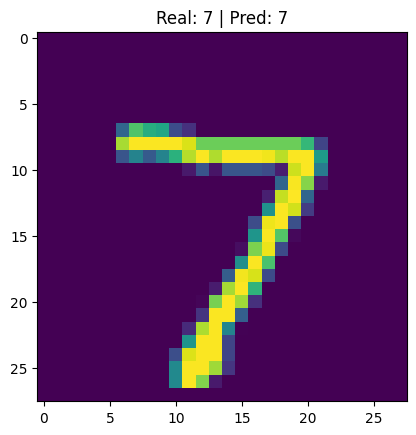

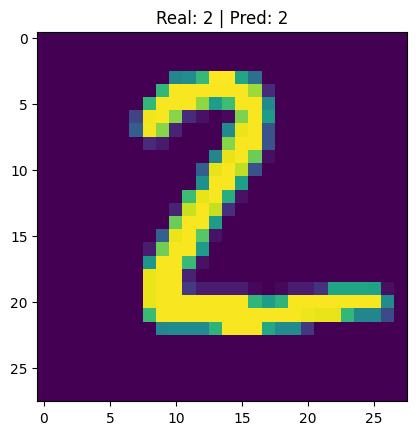

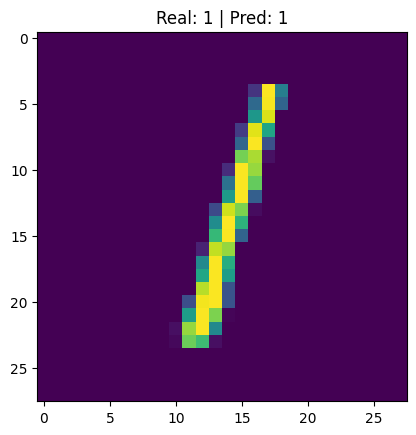

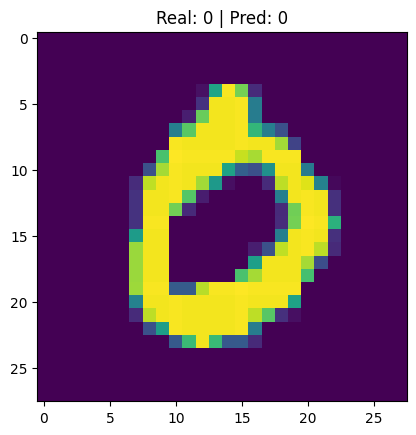

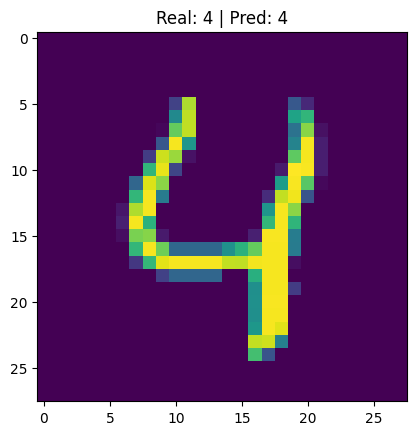

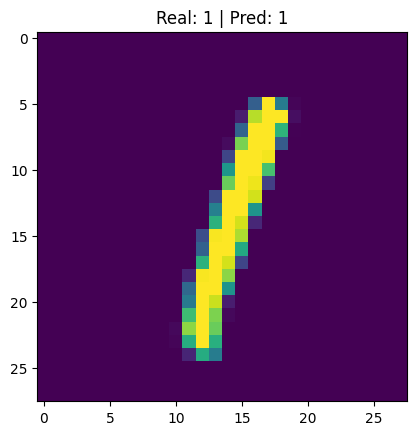

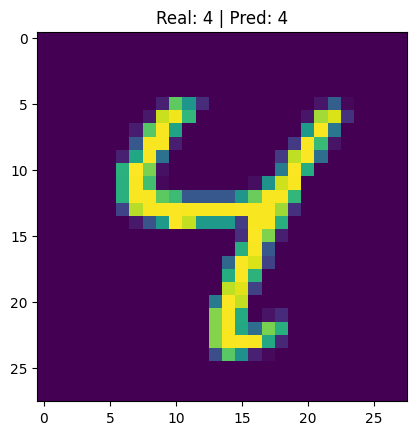

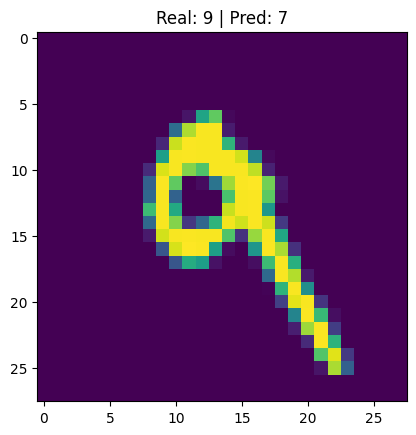

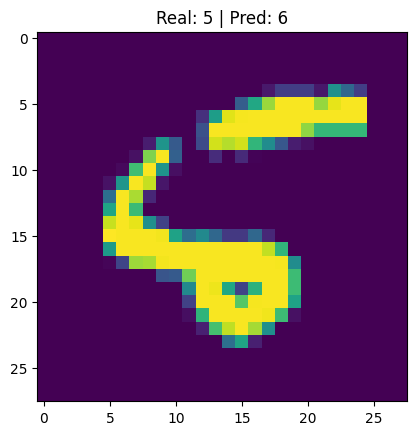

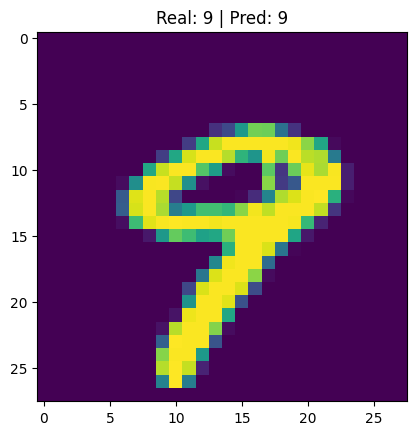

In [92]:
model = MNISTModel(input_features=NUM_FEATURES,
                   output_features=NUM_CLASSES,
                   hidden_units=20).to(device)
loss_fn = nn.CrossEntropyLoss()
opt = torch.optim.SGD(model.parameters(), lr=0.1)
preds = result_pipiline(model, loss_fn, opt, epochs=200)

data_iter = iter(test_dataset)
images, labels = next(data_iter)
for i in range(10):
    img = images[i].numpy().transpose((1, 2, 0))
    plt.imshow(img)
    plt.title(f"Real: {labels[i].item()} | Pred: {preds[i].item()}")
    plt.show()